## Задание
Домашнее задание по теме «Архитектуры свёрточных сетей»

Цель задания: изучить работу с готовыми моделями из torchvision.

Контекст
Вам необходимо подобрать базовую модель для работы по вашей задаче. Вы пробуете обучать различные модели на “ваших” данных. По результатам отберёте лучшую для дальнейшего обучения.

Задание
Вам необходимо провести эксперименты по начальному обучению различных моделей и сравнить результаты.

    Возьмите датасет EMNIST из torchvision
    Обучите на нём модели: ResNet 18, VGG 16, Inception v3, DenseNet 161 (с нуля по 10 эпох)
    Сведите результаты обучения моделей (графики лоса) в таблицу и сравните их.

Задание со звездочкой*
Выполните то же задание, используя датасет hymenoptera_data

Инструкция к выполнению задания

    Загрузите датасет, посмотрите примеры картинок в нём и проверьте наличествующие классы и их дисбаланс.
    Создайте модель текущего типа, используя интерфейс torchvision для нужного количества классов.
    Обучите модель с нуля 10 эпох. Фиксируйте значение функции потерь в список для последующего отображения.
    Повторите пункты 2 и 3 для всех указанных вариантов моделей.


##### 1. Т.к. на моём компьютере нет GPU, точнее есть, но при попытке произвести какие-либо вычисления он вылетает, пытался делать это задание в Google Colab, но и там столкнулся с недостатком вычислительных мощностей.<br>Поэтому решил обучать модели на домашнем компьютере, но не на 10, а на 3-х эпохах для сокращения времени обучения.

In [34]:
# импорт библиотек
import torch
from torch import nn
import torchvision as tv
from torchsummary import summary
import time
import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [35]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu" # строка для запуска на домашнем компьютере
# device = "cuda" # строка для запуска в Colab
print(device)

cpu


##### 2. Подготовка данных

In [36]:
# готовлю данные
BATCH_SIZE = 256 # размер батча
transoforms = tv.transforms.Compose([ # преобразование картинок по размеру и в тензор
    # tv.transforms.Grayscale(3), # преобразуеим ч/б картинку в 3-х канальную
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])
# загрузка данных. выбрал срез balanced как более интересный, в нём 47 классов, но обнаружил, что он в 2 раза больше, поэтому остановился на привычном mnist
train_dataset = tv.datasets.EMNIST('.', split="mnist", train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split="mnist", train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [37]:
train_dataset.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

##### 3. Визуализация данных

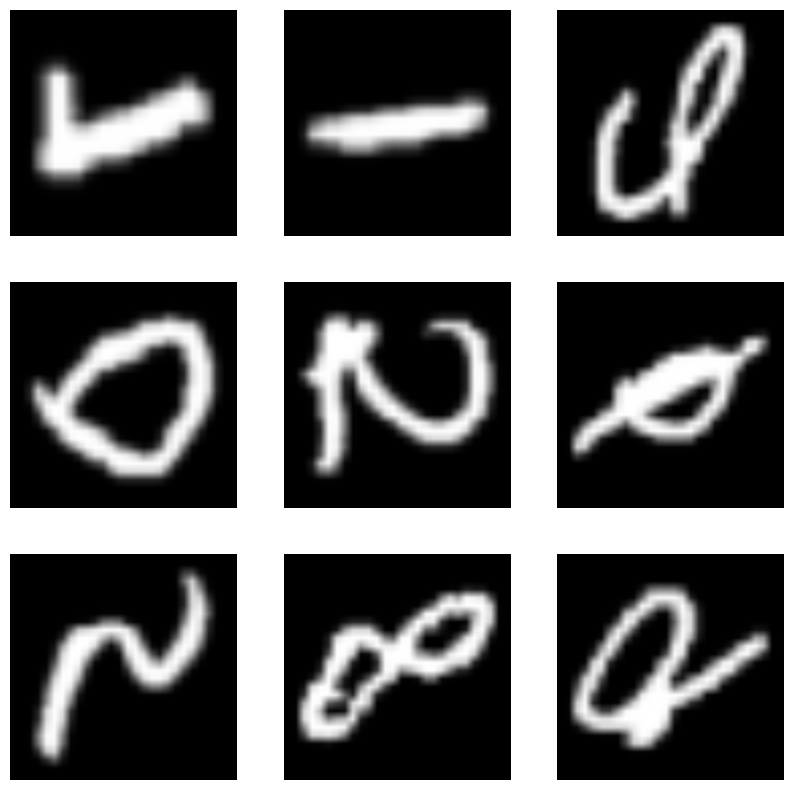

In [38]:
figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_dataset), size = (1,)).item()
    image, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

##### 4. Проверка на дисбаланс

In [39]:
targets = train_dataset.targets
counts = torch.bincount(targets)
for i, count in enumerate(counts):
    print(f"{i}: {count}")

0: 6000
1: 6000
2: 6000
3: 6000
4: 6000
5: 6000
6: 6000
7: 6000
8: 6000
9: 6000


##### 5. Создание вспомогательных функций

In [40]:
# функция оценки точности
def evaluate_accuracy(data_iter, net): # принимает даталоадер и сеть
    acc_sum, n = 0, 0 # суммы точности
    net.eval() # переводим модель в стадию оценки
    for X, y in data_iter: # проходимся циклом по данным
        X, y = X.to(device), y.to(device) # кладём данные на нужное устройство
        acc_sum += (net(X).argmax(axis=1) == y).sum() # делаем предсказание и считаем,
        n += y.shape[0] # сколько всего было объектов
    return acc_sum.item() / n

In [41]:
# создаю списки для хранения результатов
model_name_list, epoch_list, train_accuracy, train_losses, test_accuracy = [], [], [], [], []

In [42]:
# функция для обучения сети
def train(model_name, net, train_iter, test_iter, trainer, num_epochs):
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum') # категорийная кросс-энтропия для задачи многоклассовой классификации
    net.train() # переводим сеть в обущающий режим
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter): # проходимся циклом по даталоадеру
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0: # текста будет много, но для визуализации результатов оставлю как есть
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
        model_name_list.append(model_name)
        epoch_list.append(epoch+1)
        train_accuracy.append(train_acc_sum / n)
        train_losses.append(train_l_sum / n)
        test_accuracy.append(test_acc)

##### 6. Обучение моделей

In [43]:
# готовлю данные для предобученных сетей
BATCH_SIZE = 256 # размер батча
transoforms = tv.transforms.Compose([ # преобразование картинок по размеру и в тензор
    tv.transforms.Grayscale(3), # преобразуеим ч/б картинку в 3-х канальную
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])
# загрузка данных. выбрал срез balanced как более интересный, в нём 47 классов, но обнаружил, что он в 2 раза больше, поэтому остановился на привычном mnist
train_dataset = tv.datasets.EMNIST('.', split="mnist", train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split="mnist", train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

Сначала на примере одной модели делаю всё по шагам, как на лекции. Далее объединю всё в один блок.

ResNet18

In [44]:
# model = tv.models.resnet18(pretrained=True) # берём предобученный resnet18 (обучался на ImageNet)

In [45]:
# model # смотрю, что это такое

In [46]:
# model = model.to(device)

In [47]:
# summary(model, input_size=(3, 224, 224), device=device)

In [48]:
# Убираем требование градиента; замораживаем веса;
# for param in model.parameters():
#     param.requires_grad = False # указываем, что параметры не используют градиенты, т.е .слои обучаться не будут, мы можем использовать предобученные слои для
#                                 # наших задач

In [49]:
# model.fc # смотрим, что из себя представляет последний слой; посмотреть, какие слои за что отвечают можно с помощью "model"

In [50]:
# model.fc = nn.Linear(in_features=512, out_features=10) # меняем последний слой

In [51]:
# model.fc # смотрим, что из себя представляет последний слой; посмотреть, какие слои за что отвечают можно с помощью "model"

In [52]:
# print("Params to learn:") # смотрим, какие параметры являются обучаемыми
# params_to_update = [] # т.к. новый слой мы добавили после заморозки параметров, то он является обучаемым; передаём эти параметры в список
# for name, param in model.named_parameters():
#     if param.requires_grad == True:
#         params_to_update.append(param)
        # print("\t",name)

In [53]:
# trainer = torch.optim.Adam(params_to_update, lr=0.001) # передаём настройки и обучаемые параметры в оптимизатор

In [54]:
# train("ResNet18", model, train_iter, test_iter, trainer, 2) # запускаем обучение модели

##### Начинаю обучение моделей

In [55]:
start_time = datetime.datetime.now()

In [56]:
# ResNet18

model_name = "ResNet18" # УКАЗАТЬ НАЗВАНИЕ МОДЕЛИ
num_epochs = 5 # УКАЗАТЬ КОЛИЧЕСТВО ЭПОХ

torch.cuda.empty_cache() # очистка кэша
model = tv.models.resnet18(weights='DEFAULT') # УКАЗАТЬ МОДЕЛЬ
model = model.to(device)


for param in model.parameters(): # Убираем требование градиента; замораживаем веса;
  param.requires_grad = False

model.fc = nn.Linear(in_features=512, out_features=10) # НАСТРОИТЬ ПОСЛЕДНИЙ СЛОЙ

params_to_update = [] # определяем обучаемые параметры
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

trainer = torch.optim.Adam(params_to_update, lr=0.001) # передаём настройки и обучаемые параметры в оптимизатор

train(model_name == model_name, model, train_iter, test_iter, trainer, num_epochs) # УКАЗАТЬ

Step 0. time since epoch: 3.547. Train acc: 0.105. Train Loss: 2.393
Step 10. time since epoch: 33.684. Train acc: 0.317. Train Loss: 2.057
Step 20. time since epoch: 63.437. Train acc: 0.481. Train Loss: 1.800
Step 30. time since epoch: 96.319. Train acc: 0.583. Train Loss: 1.598
Step 40. time since epoch: 127.891. Train acc: 0.646. Train Loss: 1.435
Step 50. time since epoch: 161.557. Train acc: 0.689. Train Loss: 1.307
Step 60. time since epoch: 192.934. Train acc: 0.719. Train Loss: 1.206
Step 70. time since epoch: 223.785. Train acc: 0.744. Train Loss: 1.122
Step 80. time since epoch: 254.917. Train acc: 0.764. Train Loss: 1.051
Step 90. time since epoch: 289.043. Train acc: 0.780. Train Loss: 0.990
Step 100. time since epoch: 322.349. Train acc: 0.793. Train Loss: 0.939
Step 110. time since epoch: 353.167. Train acc: 0.804. Train Loss: 0.894
Step 120. time since epoch: 384.384. Train acc: 0.813. Train Loss: 0.855
Step 130. time since epoch: 417.251. Train acc: 0.822. Train Loss: 

In [57]:
# VGG16

model_name = "VGG16" # УКАЗАТЬ НАЗВАНИЕ МОДЕЛИ
num_epochs = 5 # УКАЗАТЬ КОЛИЧЕСТВО ЭПОХ

torch.cuda.empty_cache() # очистка кэша
model = tv.models.vgg16(weights='DEFAULT') # УКАЗАТЬ МОДЕЛЬ
model = model.to(device)

# с VGG пришлось сначала посмотреть, что это за модель, какой у неё классификатор и какой последний слой
model
model.classifier
# model.classifier[6] # Linear(in_features=4096, out_features=1000, bias=True)

for param in model.parameters(): # Убираем требование градиента; замораживаем веса;
  param.requires_grad = False

model.classifier[6] = nn.Linear(in_features=4096, out_features=10) # НАСТРОИТЬ ПОСЛЕДНИЙ СЛОЙ

params_to_update = [] # определяем обучаемые параметры
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

trainer = torch.optim.Adam(params_to_update, lr=0.001) # передаём настройки и обучаемые параметры в оптимизатор

train(model_name == model_name, model, train_iter, test_iter, trainer, num_epochs) # УКАЗАТЬ

Step 0. time since epoch: 17.332. Train acc: 0.102. Train Loss: 2.372
Step 10. time since epoch: 187.314. Train acc: 0.419. Train Loss: 1.850
Step 20. time since epoch: 356.274. Train acc: 0.556. Train Loss: 1.539
Step 30. time since epoch: 526.312. Train acc: 0.624. Train Loss: 1.339
Step 40. time since epoch: 701.212. Train acc: 0.667. Train Loss: 1.199
Step 50. time since epoch: 867.567. Train acc: 0.694. Train Loss: 1.099
Step 60. time since epoch: 1038.144. Train acc: 0.715. Train Loss: 1.024
Step 70. time since epoch: 1210.377. Train acc: 0.733. Train Loss: 0.964
Step 80. time since epoch: 1377.626. Train acc: 0.746. Train Loss: 0.915
Step 90. time since epoch: 1541.961. Train acc: 0.758. Train Loss: 0.873
Step 100. time since epoch: 1707.795. Train acc: 0.767. Train Loss: 0.837
Step 110. time since epoch: 1877.606. Train acc: 0.775. Train Loss: 0.808
Step 120. time since epoch: 2047.699. Train acc: 0.782. Train Loss: 0.781
Step 130. time since epoch: 2218.356. Train acc: 0.788. 

In [58]:
# DenseNet161

model_name = "DenseNet161" # УКАЗАТЬ НАЗВАНИЕ МОДЕЛИ
num_epochs = 5 # УКАЗАТЬ КОЛИЧЕСТВО ЭПОХ

torch.cuda.empty_cache() # очистка кэша
model = tv.models.densenet161(weights='DEFAULT') # УКАЗАТЬ МОДЕЛЬ
model = model.to(device)

# с VGG пришлось сначала посмотреть, что это за модель, какой у неё классификатор и какой последний слой
model
model.classifier

for param in model.parameters(): # Убираем требование градиента; замораживаем веса;
  param.requires_grad = False

model.classifier = nn.Linear(in_features=2208, out_features=10) # НАСТРОИТЬ ПОСЛЕДНИЙ СЛОЙ

params_to_update = [] # определяем обучаемые параметры
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

trainer = torch.optim.Adam(params_to_update, lr=0.001) # передаём настройки и обучаемые параметры в оптимизатор

train(model_name == model_name, model, train_iter, test_iter, trainer, num_epochs) # УКАЗАТЬ

Step 0. time since epoch: 21.871. Train acc: 0.098. Train Loss: 2.360
Step 10. time since epoch: 238.704. Train acc: 0.362. Train Loss: 1.996
Step 20. time since epoch: 455.434. Train acc: 0.535. Train Loss: 1.724
Step 30. time since epoch: 670.906. Train acc: 0.626. Train Loss: 1.514
Step 40. time since epoch: 886.118. Train acc: 0.679. Train Loss: 1.355
Step 50. time since epoch: 1103.025. Train acc: 0.718. Train Loss: 1.230
Step 60. time since epoch: 1320.262. Train acc: 0.745. Train Loss: 1.132
Step 70. time since epoch: 1537.889. Train acc: 0.765. Train Loss: 1.053
Step 80. time since epoch: 1755.168. Train acc: 0.781. Train Loss: 0.988
Step 90. time since epoch: 1972.447. Train acc: 0.795. Train Loss: 0.931
Step 100. time since epoch: 2189.784. Train acc: 0.805. Train Loss: 0.883
Step 110. time since epoch: 2409.241. Train acc: 0.815. Train Loss: 0.842
Step 120. time since epoch: 2629.136. Train acc: 0.823. Train Loss: 0.806
Step 130. time since epoch: 2849.014. Train acc: 0.831.

##### Inception оказалась очень капризной моделью, тек и не смог разобраться, как запустить предобученную модель, постоянно выдаёт ошибку.<br>Скорее всего, стандартная функция train не подходит для этой модели. <br> Поэтому решил использовать код модели из лекции.

In [59]:
# Inceptionv3

# BATCH_SIZE = 256 # размер батча
# transoforms = tv.transforms.Compose([ # преобразование картинок по размеру и в тензор
#     tv.transforms.Grayscale(3), # преобразуеим ч/б картинку в 3-х канальную
#     tv.transforms.Resize((299)),
#     tv.transforms.ToTensor()
# ])
# # загрузка данных. выбрал срез balanced как более интересный, в нём 47 классов, но обнаружил, что он в 2 раза больше, поэтому остановился на привычном mnist
# train_dataset = tv.datasets.EMNIST('.', split="mnist", train=True, transform=transoforms, download=True)
# test_dataset = tv.datasets.EMNIST('.', split="mnist", train=False, transform=transoforms, download=True)
# train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
# test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

# model_name = "Inceptionv3" # УКАЗАТЬ НАЗВАНИЕ МОДЕЛИ
# num_epochs = 1 # УКАЗАТЬ КОЛИЧЕСТВО ЭПОХ

# torch.cuda.empty_cache() # очистка кэша
# model = tv.models.inception_v3(weights='DEFAULT') # УКАЗАТЬ МОДЕЛЬ
# model = model.to(device)

# # с VGG пришлось сначала посмотреть, что это за модель, какой у неё классификатор и какой последний слой
# model
# # model.fc

# for param in model.parameters(): # Убираем требование градиента; замораживаем веса;
#   param.requires_grad = False

# model.fc = nn.Linear(in_features=2048, out_features=10) # НАСТРОИТЬ ПОСЛЕДНИЙ СЛОЙ

# print("Params to learn:") # смотрим, какие параметры являются обучаемыми
# params_to_update = [] # т.к. новый слой мы добавили после заморозки параметров, то он является обучаемым; передаём эти параметры в список
# for name, param in model.named_parameters():
#     if param.requires_grad == True:
#         params_to_update.append(param)
#         print("\t",name)

# summary(model, input_size=(3, 299, 299), device="cpu")

# trainer = torch.optim.Adam(params_to_update, lr=0.001) # передаём настройки и обучаемые параметры в оптимизатор

# train(model_name == model_name, model, train_iter, test_iter, trainer, num_epochs) # УКАЗАТЬ

##### Ниже код модели из лекции. Для неё нужно снова трансформировать данныв 1 канал.

In [60]:
# готовлю данные
BATCH_SIZE = 256 # размер батча
transoforms = tv.transforms.Compose([ # преобразование картинок по размеру и в тензор
    # tv.transforms.Grayscale(3), # преобразуеим ч/б картинку в 3-х канальную
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor()
])
# загрузка данных. выбрал срез balanced как более интересный, в нём 47 классов, но обнаружил, что он в 2 раза больше, поэтому остановился на привычном mnist
train_dataset = tv.datasets.EMNIST('.', split="mnist", train=True, transform=transoforms, download=True)
test_dataset = tv.datasets.EMNIST('.', split="mnist", train=False, transform=transoforms, download=True)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [61]:
nn.Module # для этой сети нужно обязательно наследоваться от nn.Module
class Inception(nn.Module): # создаём класс
    def __init__(self, ic, c1, c2, c3, c4, **kwargs): # на вход принимает кол-вл входное кол-во каналов и кол-во каналов после 1, 2, 3 и 4 нитки, а также доп параметры
                                                      # **kwargs
        super(Inception, self).__init__(**kwargs) # передаём доп. аргументы
        # ниже создаю нитки
        self.p1_1 = nn.Sequential(nn.Conv2d(ic, c1, kernel_size=1), nn.ReLU()) # 1
        self.p2_1 = nn.Sequential(nn.Conv2d(ic, c2[0], kernel_size=1), nn.ReLU()) # 2
        self.p2_2 = nn.Sequential(nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1), nn.ReLU()) # 2
        self.p3_1 = nn.Sequential(nn.Conv2d(ic, c3[0], kernel_size=1), nn.ReLU()) # 3
        self.p3_2 = nn.Sequential(nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2), nn.ReLU()) # 3
        self.p4_1 = nn.Sequential(nn.MaxPool2d(3, stride=1, padding=1)) # 4
        self.p4_2 = nn.Sequential(nn.Conv2d(ic, c4, kernel_size=1), nn.ReLU()) # 4

    # реализуем метод, в котором соединяются слои, на вход принимае изображение
    def forward(self, x):
        p1 = self.p1_1(x)
        p2 = self.p2_2(self.p2_1(x))
        p3 = self.p3_2(self.p3_1(x))
        p4 = self.p4_2(self.p4_1(x))
        # Concatenate the outputs on the channel dimension.
        return torch.cat((p1, p2, p3, p4), dim=1) # конкатинируем все выходы вместе
    
    # 1 блок
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3), nn.ReLU(),
       nn.MaxPool2d(3, stride=2, padding=1))

# 2 блок
b2 = nn.Sequential(
       nn.Conv2d(64, 64, kernel_size=1),
       nn.Conv2d(64, 192, kernel_size=3, padding=1),
       nn.MaxPool2d(3, stride=2, padding=1))

# создаём блок inception; Stage 3 - 2 блока inception и макс пулинг
b3 = nn.Sequential(
       Inception(192, 64, (96, 128), (16, 32), 32), # 1-й модуль inception 192 - входное кол-во параметров, 64 - выходное после 1-й нитки, (96, 128) - выходное после 2-й нитки итд.
       Inception(256, 128, (128, 192), (32, 96), 64), # 2-й модуль inception
       nn.MaxPool2d(3, stride=2, padding=1))

b4 = nn.Sequential( # Stage 4 - 5 блоков inception и макс пулинг
       Inception(480, 192, (96, 208), (16, 48), 64),
       Inception(512, 160, (112, 224), (24, 64), 64),
       Inception(512, 128, (128, 256), (24, 64), 64),
       Inception(512, 112, (144, 288), (32, 64), 64),
       Inception(528, 256, (160, 320), (32, 128), 128),
       nn.MaxPool2d(3, stride=2, padding=1))

b5 = nn.Sequential( # Stage 5 - 2 блока inception и avg пулинг
       Inception(832, 256, (160, 320), (32, 128), 128),
       Inception(832, 384, (192, 384), (48, 128), 128),
       nn.AvgPool2d(7)) # в Pytorch глобального усредняющего пулинга как отдельного слоя нет, поэтому берём обычный усредняющий пулинг

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Flatten(), nn.Linear(1024, 10)) # создаём сеть

In [62]:
summary(net, input_size=(1, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,200
              ReLU-2         [-1, 64, 112, 112]               0
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]           4,160
            Conv2d-5          [-1, 192, 56, 56]         110,784
         MaxPool2d-6          [-1, 192, 28, 28]               0
            Conv2d-7           [-1, 64, 28, 28]          12,352
              ReLU-8           [-1, 64, 28, 28]               0
            Conv2d-9           [-1, 96, 28, 28]          18,528
             ReLU-10           [-1, 96, 28, 28]               0
           Conv2d-11          [-1, 128, 28, 28]         110,720
             ReLU-12          [-1, 128, 28, 28]               0
           Conv2d-13           [-1, 16, 28, 28]           3,088
             ReLU-14           [-1, 16,

In [63]:
num_epochs = 5
trainer = torch.optim.Adam(net.parameters(), lr=0.001) # передаём настройки и обучаемые параметры в оптимизатор
train("Inception", net, train_iter, test_iter, trainer, num_epochs) # УКАЗАТЬ

Step 0. time since epoch: 10.491. Train acc: 0.090. Train Loss: 2.303
Step 10. time since epoch: 109.614. Train acc: 0.098. Train Loss: 2.305
Step 20. time since epoch: 206.379. Train acc: 0.101. Train Loss: 2.303
Step 30. time since epoch: 301.981. Train acc: 0.102. Train Loss: 2.303
Step 40. time since epoch: 396.817. Train acc: 0.100. Train Loss: 2.303
Step 50. time since epoch: 491.705. Train acc: 0.102. Train Loss: 2.304
Step 60. time since epoch: 585.041. Train acc: 0.101. Train Loss: 2.304
Step 70. time since epoch: 678.487. Train acc: 0.102. Train Loss: 2.304
Step 80. time since epoch: 771.493. Train acc: 0.102. Train Loss: 2.304
Step 90. time since epoch: 864.645. Train acc: 0.102. Train Loss: 2.304
Step 100. time since epoch: 957.631. Train acc: 0.103. Train Loss: 2.304
Step 110. time since epoch: 1050.701. Train acc: 0.102. Train Loss: 2.304
Step 120. time since epoch: 1144.476. Train acc: 0.102. Train Loss: 2.304
Step 130. time since epoch: 1238.056. Train acc: 0.102. Train

In [64]:
end_time = datetime.datetime.now()

##### 7. После окончания обучения вывожу затраченное время.<br>Свожу результаты в датафрейм для дальнейшего анализа.

In [65]:
print(f'start_time:\t{start_time}')
print(f'end_time:\t{end_time}')

start_time:	2024-02-22 01:03:23.950745
end_time:	2024-02-22 19:29:37.088916


In [66]:
model_name_list, epoch_list, train_accuracy, train_losses, test_accuracy

([True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  'Inception',
  'Inception',
  'Inception',
  'Inception',
  'Inception'],
 [1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
 [0.8720833333333333,
  0.9511166666666667,
  0.9598333333333333,
  0.9649,
  0.9679666666666666,
  0.82605,
  0.9459,
  0.9596666666666667,
  0.96685,
  0.9715166666666667,
  0.8746833333333334,
  0.9503,
  0.9611333333333333,
  0.9667166666666667,
  0.96995,
  0.10106666666666667,
  0.10006666666666666,
  0.10143333333333333,
  0.09951666666666667,
  0.10773333333333333],
 [0.5970544897079467,
  0.21398374942143758,
  0.16166956033706664,
  0.13678874905904134,
  0.12161968987782797,
  0.6090317849477133,
  0.22734006131490073,
  0.1622583583831787,
  0.13143651413917543,
  0.11216536382039388,
  0.569676894124349,
  0.21082688264846802,
  0.1574903009414673,
  0.1315180046081543,
  0.1153987016359965,
  2.303256194051107,
  2.30

In [67]:
df_results= pd.DataFrame(columns = ['model', 'epoch', 'train_accuracy', 'train_loss', 'test_accuracy'])
for i in range(len(model_name_list)):
  df_results.loc[len(df_results.index)] = [model_name_list[i], epoch_list[i], train_accuracy[i], train_losses[i], test_accuracy[i]]
df_results.to_csv('Results.csv')

In [68]:
df_results

,model,epoch,train_accuracy,train_loss,test_accuracy
0,True,1,0.872083,0.597054,0.9451
1,True,2,0.951117,0.213984,0.9574
2,True,3,0.959833,0.161670,0.9635
3,True,4,0.964900,0.136789,0.9669
4,True,5,0.967967,0.121620,0.9682
5,True,1,0.826050,0.609032,0.9302
6,True,2,0.945900,0.227340,0.9530
7,True,3,0.959667,0.162258,0.9629
8,True,4,0.966850,0.131437,0.9684
9,True,5,0.971517,0.112165,0.9718


##### Из-за ошибки в коде названия первых 3-х моделей приняли значения True, создаю резервную копию датафрейма и переименовываю значения.

In [71]:
df_backup = df_results.copy()

In [81]:
df_results.loc[0:4, 'model'].replace(True, 'ResNet18', inplace=True)
df_results.loc[5:9, 'model'].replace(True, 'VGG16', inplace=True)
df_results.loc[10:14, 'model'].replace(True, 'DenseNet161', inplace=True)
df_results

,model,epoch,train_accuracy,train_loss,test_accuracy
0,ResNet18,1,0.872083,0.597054,0.9451
1,ResNet18,2,0.951117,0.213984,0.9574
2,ResNet18,3,0.959833,0.161670,0.9635
3,ResNet18,4,0.964900,0.136789,0.9669
4,ResNet18,5,0.967967,0.121620,0.9682
5,VGG16,1,0.826050,0.609032,0.9302
6,VGG16,2,0.945900,0.227340,0.9530
7,VGG16,3,0.959667,0.162258,0.9629
8,VGG16,4,0.966850,0.131437,0.9684
9,VGG16,5,0.971517,0.112165,0.9718


##### Смотрю, что получилось по каждой из моделей выше. Первые 3 показали неплохие и сопоставимые результаты, а вот с Inception что-то не задалось, но учитывая время, затраченное на обучение, перезапускать уже не буду.
##### Учитывая, что в первую очередь интересуют данные на выходе каждой из моделей, фильтрую модели по последней эпохе. Видно, что лучший результат показывает VGG16 - accuracy и на тесте, и на трейне самая высокая, а значение loss минимальное.

In [83]:
df_results[df_results['epoch']==5]

,model,epoch,train_accuracy,train_loss,test_accuracy
4,ResNet18,5,0.967967,0.121620,0.9682
9,VGG16,5,0.971517,0.112165,0.9718
14,DenseNet161,5,0.969950,0.115399,0.9667
19,Inception,5,0.107733,2.319904,0.1000
